In [56]:
from warnings import filterwarnings

In [57]:
filterwarnings("ignore")

S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США

In [58]:
import pandas as pd

data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data = data.rename(columns={'GDP (current US$)':'gdp'})
data.head()

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


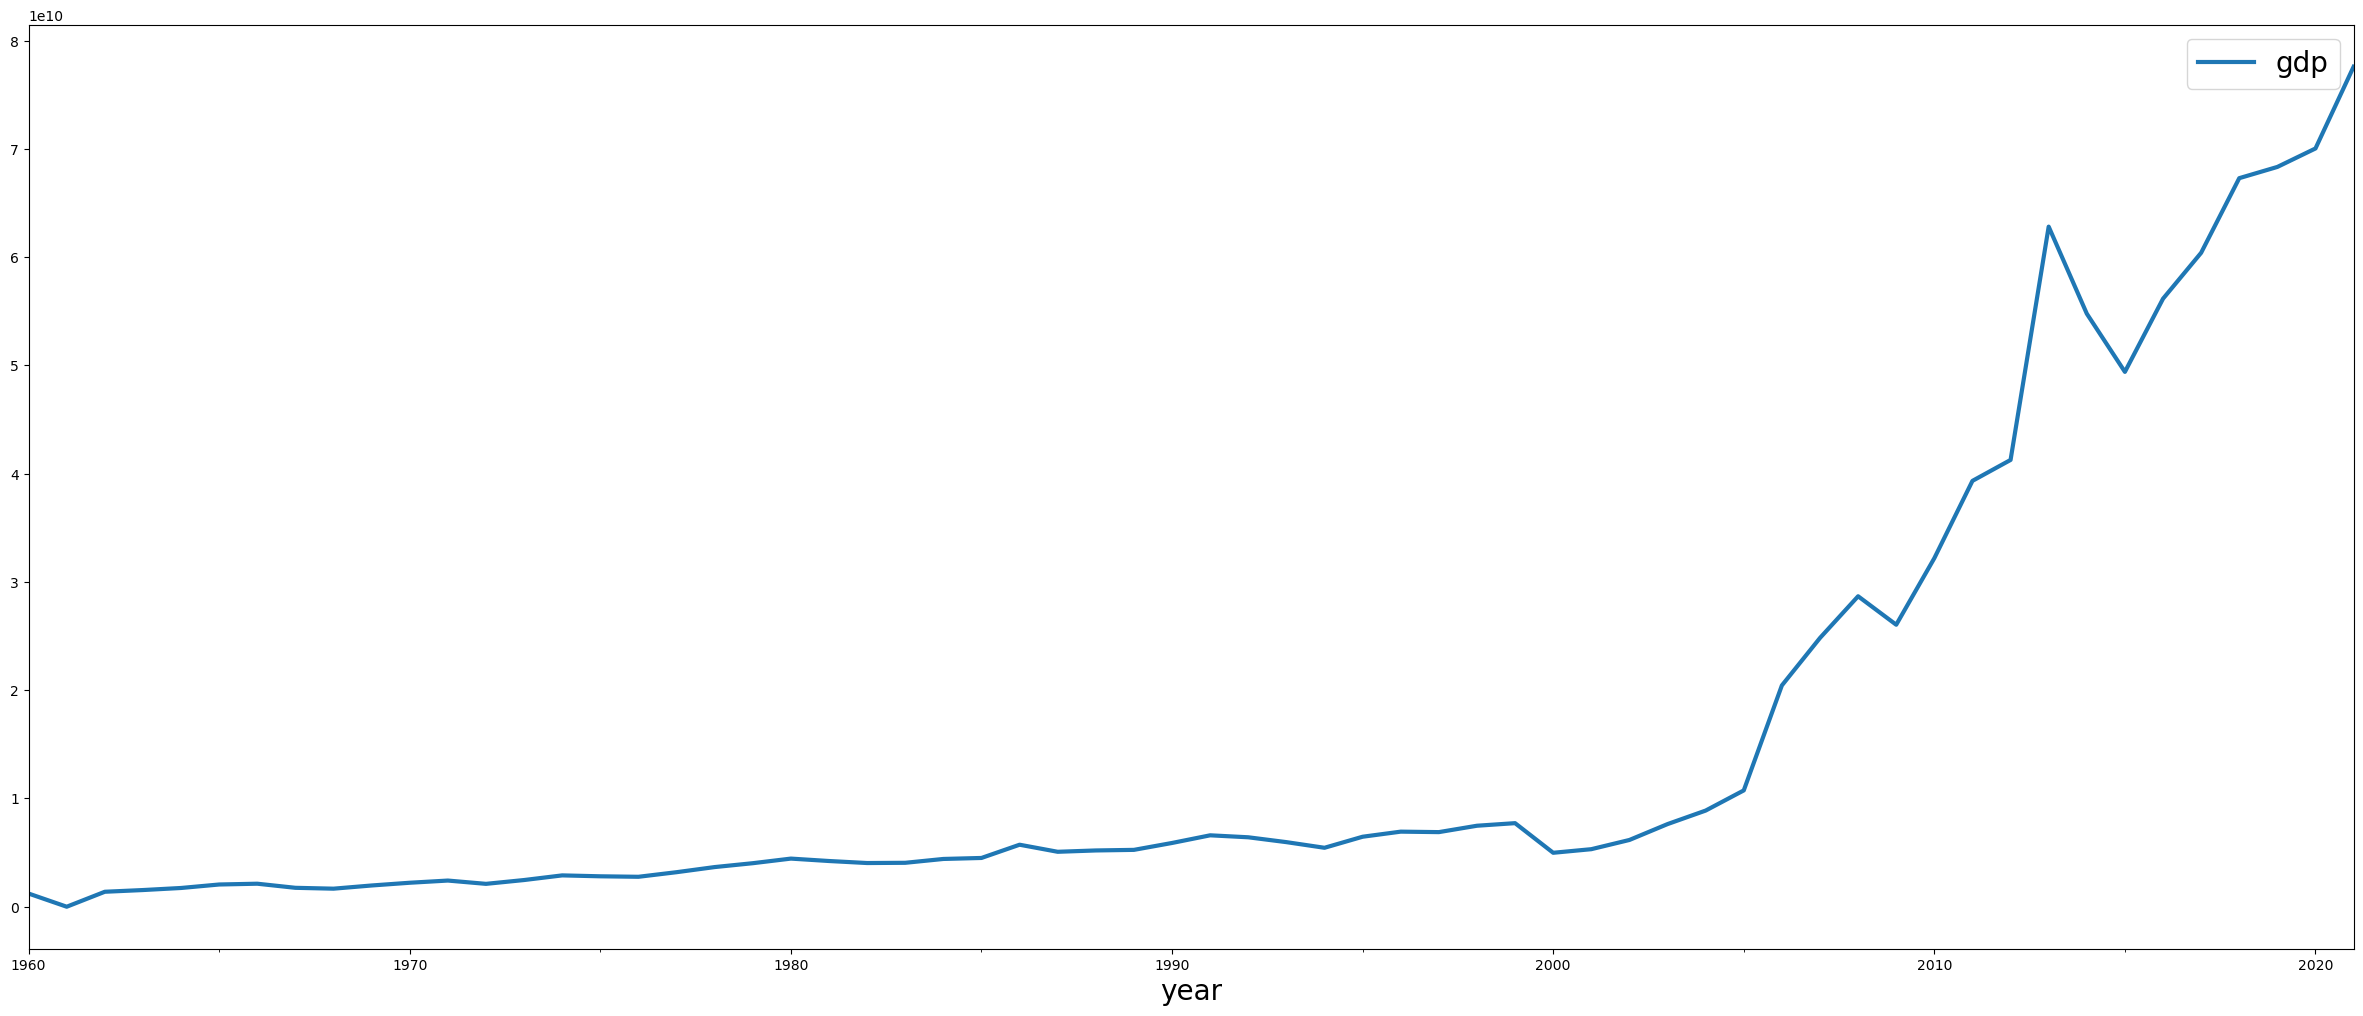

In [59]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [60]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

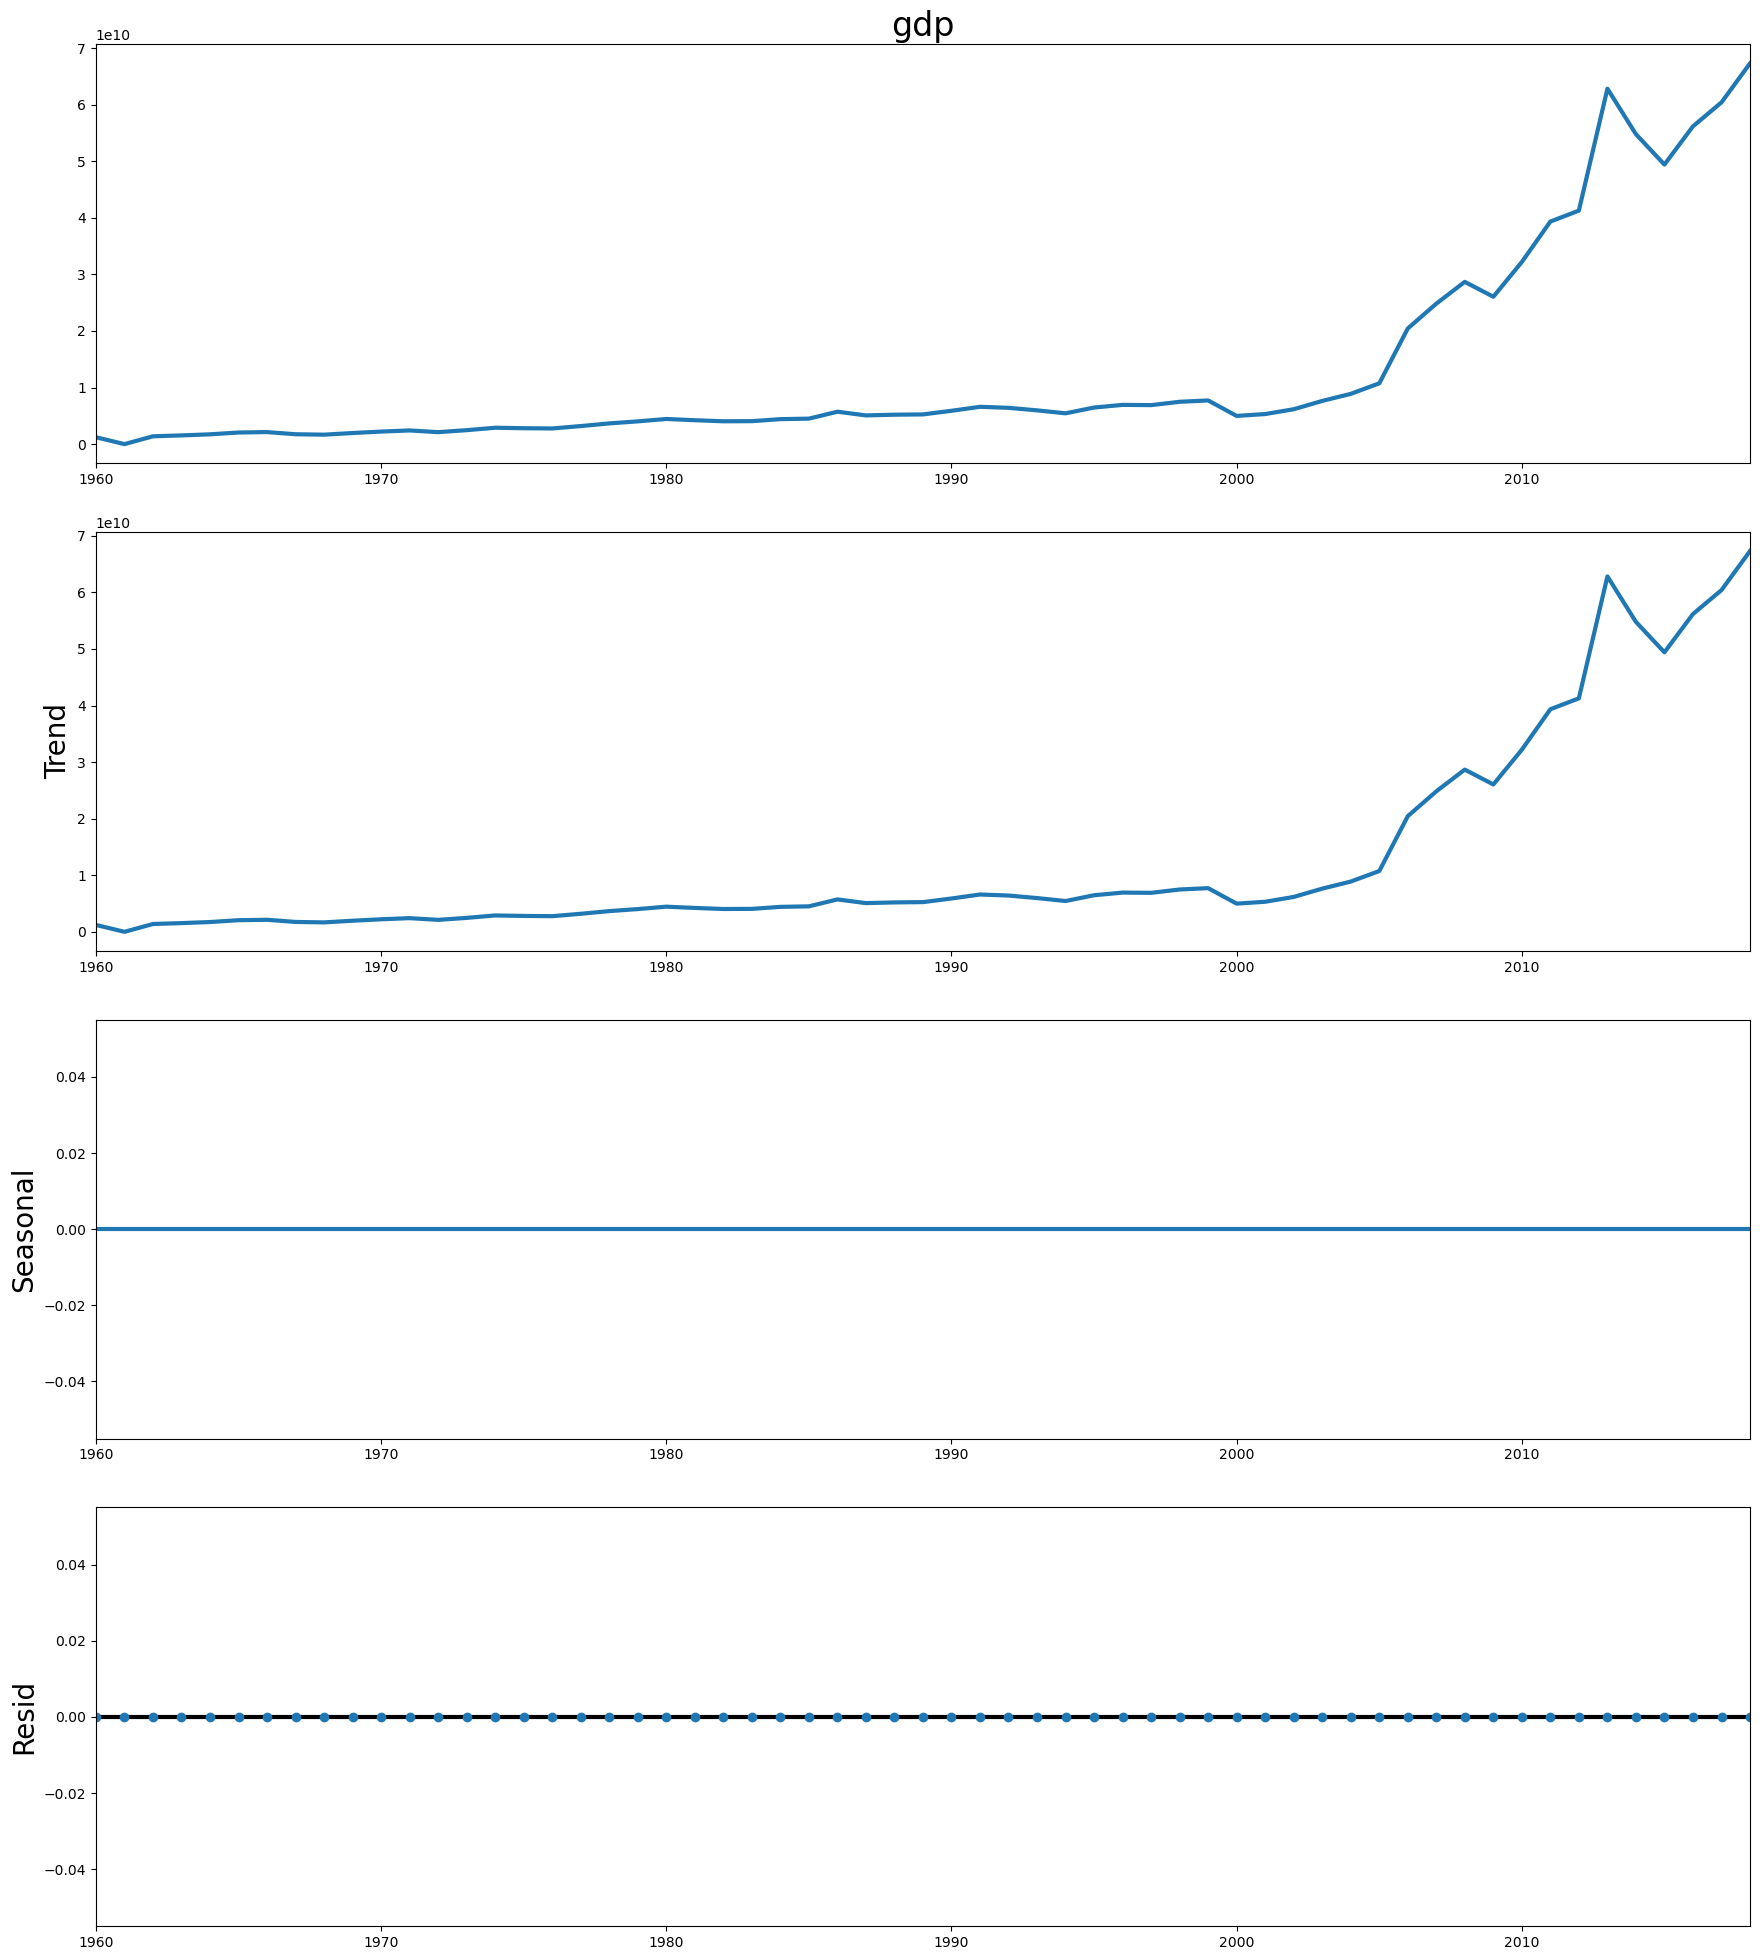

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.gdp)
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

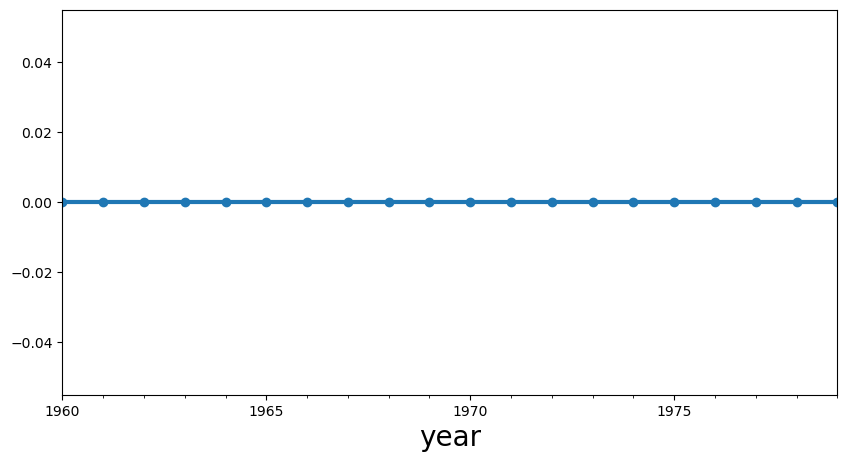

In [62]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

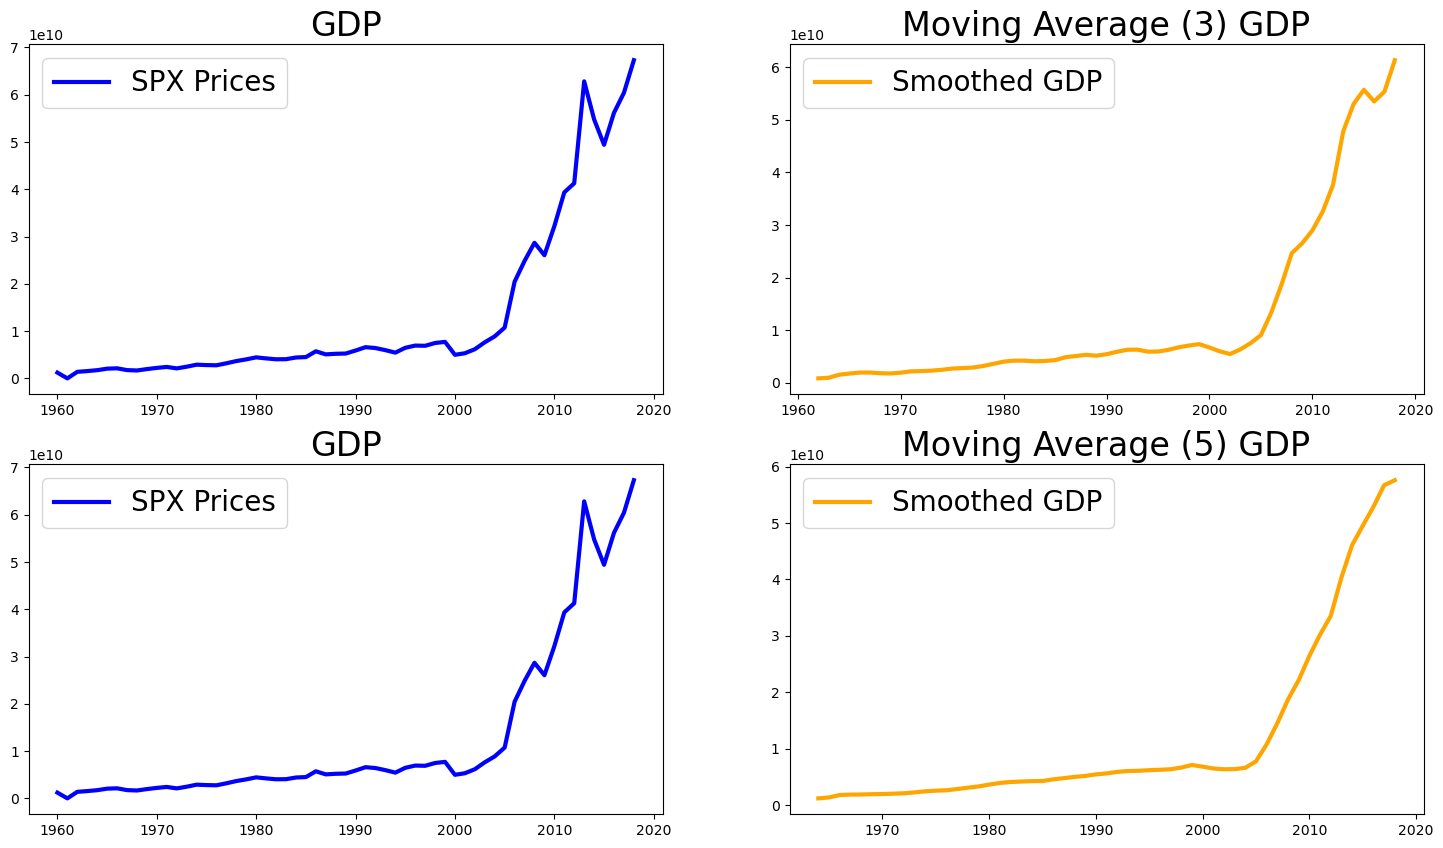

In [63]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в 3 года (Window = 3)
ax[0, 0].plot(train_df.gdp, color="blue", label="SPX Prices")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=3).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[0, 1].set_title("Moving Average (3) GDP", size=24)
ax[0, 1].legend()


# Окно в 5 лет (Window = 5)
ax[1, 0].plot(train_df.gdp, color="blue", label="SPX Prices")
ax[1, 0].set_title("GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1, 1].set_title("Moving Average (5) GDP", size=24)
ax[1, 1].legend()

plt.show()

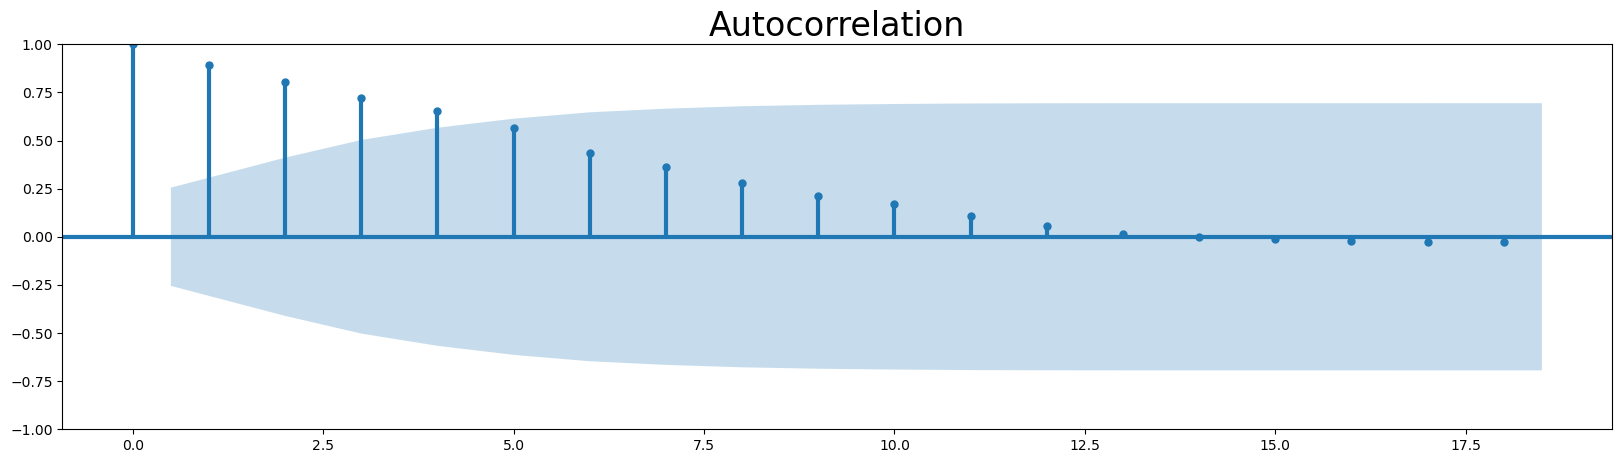

In [64]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.gdp)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

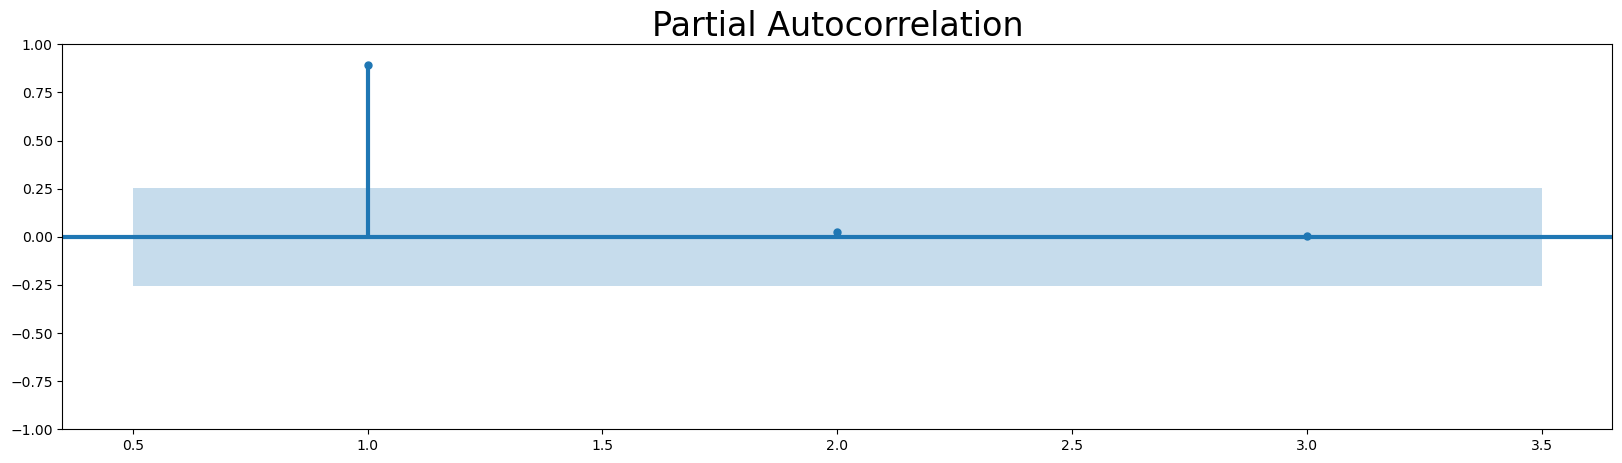

In [65]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.gdp, lags=3, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [66]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["gdp"])

(0.6529066974885405,
 0.9888496277665573,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [67]:
test1 = adfuller(train_df["gdp"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [68]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=5)
    sgt.plot_pacf(series, ax=axes[1], lags=5, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

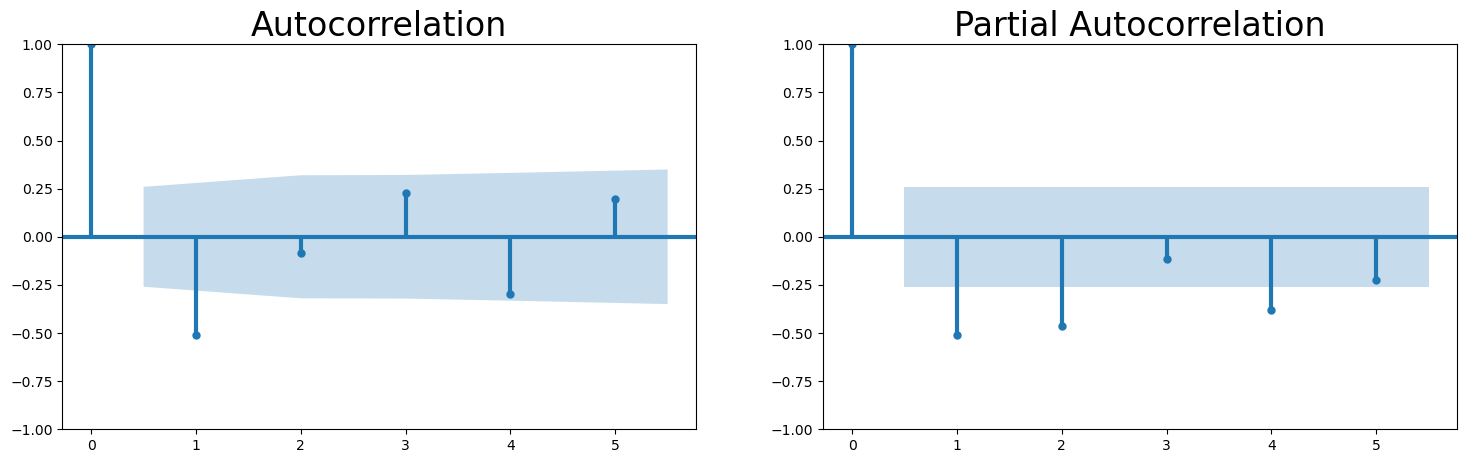

(-2.6408690561284924,
 0.08484116917837625,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [69]:
plot_acf_pacf(train_df["gdp"].diff().diff().dropna())
adfuller(train_df["gdp"].diff().diff().dropna())

Первые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [70]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.818, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.375, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.844, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.273, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2493.722, Time=0.28 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=2493.670, Time=0.42 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.817, Time=0.46 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.547, Time=0.03 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2490.649, Time=0.16 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2497.730, Time=0.13 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2492.646, Time=0.25 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2492.644, Time=0.33 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.135
Date:                                Mon, 01 May 2023   AIC                           2486.271
Time:                                        18:22:06   BIC                           2502.033
Sample:                                             0   HQIC                          2492.332
                                                 - 59                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4193      0.148     -2.837      0.005      -0.709      -0.130
ar.L2         -0.9987      0.191     -5.233      0.000      -1.373      -0.625
ma.L1          0.3671      0.243      1.509      0.131      -0.110       0.844
ma.L2          0.9209      0.214      4.297      0.000       0.501       1.341
ma.L3          0.4130      0.197      2.091      0.037       0.026       0.800
ma.S.L5        0.0449      0.270      0.166      0.868      -0.485       0.575
ma.S.L10      -0.4538      0.314     -1.444      0.149      -1.070       0.162
sigma2      1.363e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              63.50   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+53. Standard errors may be unstable.
"""

In [71]:
smodel

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 1, 2, 5),
      suppress_warnings=True, with_intercept=False)

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seas_model = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11697D+01    |proj g|=  3.72492D-01

At iterate    5    f=  2.10269D+01    |proj g|=  4.40461D-02

At iterate   10    f=  2.10171D+01    |proj g|=  3.68232D-02


 This problem is unconstrained.



At iterate   15    f=  2.09666D+01    |proj g|=  3.26169D-02

At iterate   20    f=  2.09512D+01    |proj g|=  5.73358D-02

At iterate   25    f=  2.09366D+01    |proj g|=  4.25022D-02

At iterate   30    f=  2.09355D+01    |proj g|=  2.89909D-03

At iterate   35    f=  2.09354D+01    |proj g|=  1.92070D-03

At iterate   40    f=  2.09354D+01    |proj g|=  7.74590D-03

At iterate   45    f=  2.09347D+01    |proj g|=  1.46883D-02

At iterate   50    f=  2.09345D+01    |proj g|=  4.33520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   4.335D-03   2.093D+01
  F =   20.9344985315

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.135
Date:                                Mon, 01 May 2023   AIC                           2486.271
Time:                                        18:22:07   BIC                           2502.033
Sample:                                    01-01-1960   HQIC                          2492.332
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4193      0.148     -2.837      0.005      -0.709      -0.130
ar.L2         -0.9987      0.191     -5.233      0.000      -1.373      -0.625
ma.L1          0.3671      0.243      1.509      0.131      -0.110       0.844
ma.L2          0.9209      0.214      4.297      0.000       0.501       1.341
ma.L3          0.4130      0.197      2.091      0.037       0.026       0.800
ma.S.L5        0.0449      0.270      0.166      0.868      -0.485       0.575
ma.S.L10      -0.4538      0.314     -1.444      0.149      -1.070       0.162
sigma2      1.363e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              63.50   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.39e+53. Standard errors may be unstable.
"""

In [73]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = data["gdp"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

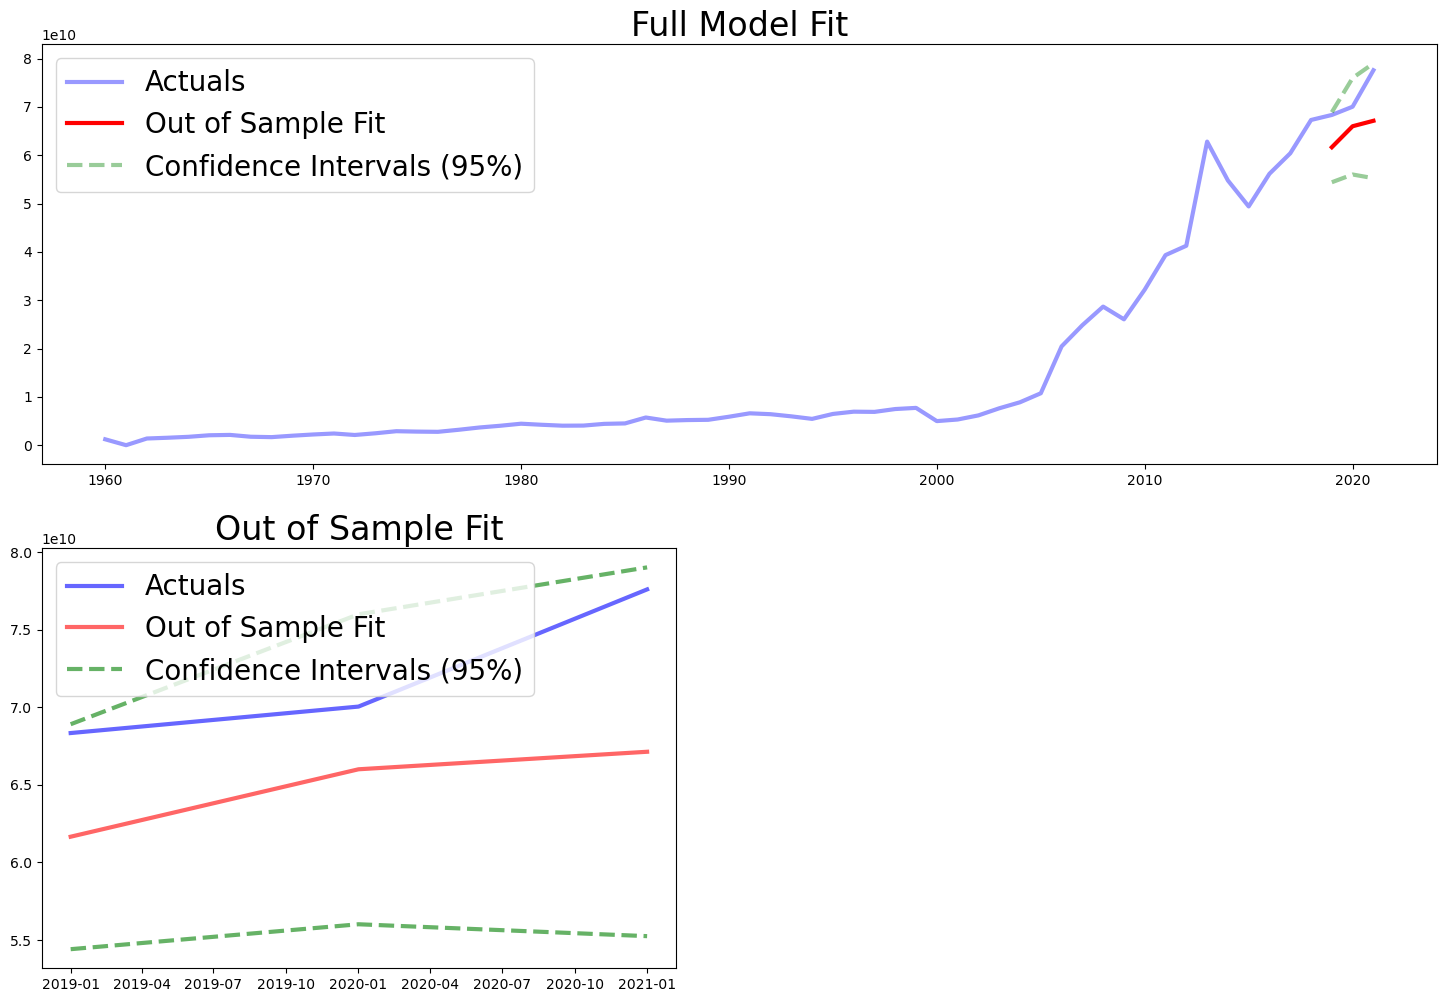

In [74]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [75]:
data.asfreq(freq='AS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [76]:
data.isna().sum()

gdp    0
dtype: int64

In [77]:
import numpy as np
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)

In [78]:
data = data.interpolate()
data.isna().sum()

gdp    0
dtype: int64

In [79]:
data.isna().sum()

gdp    0
dtype: int64

In [80]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

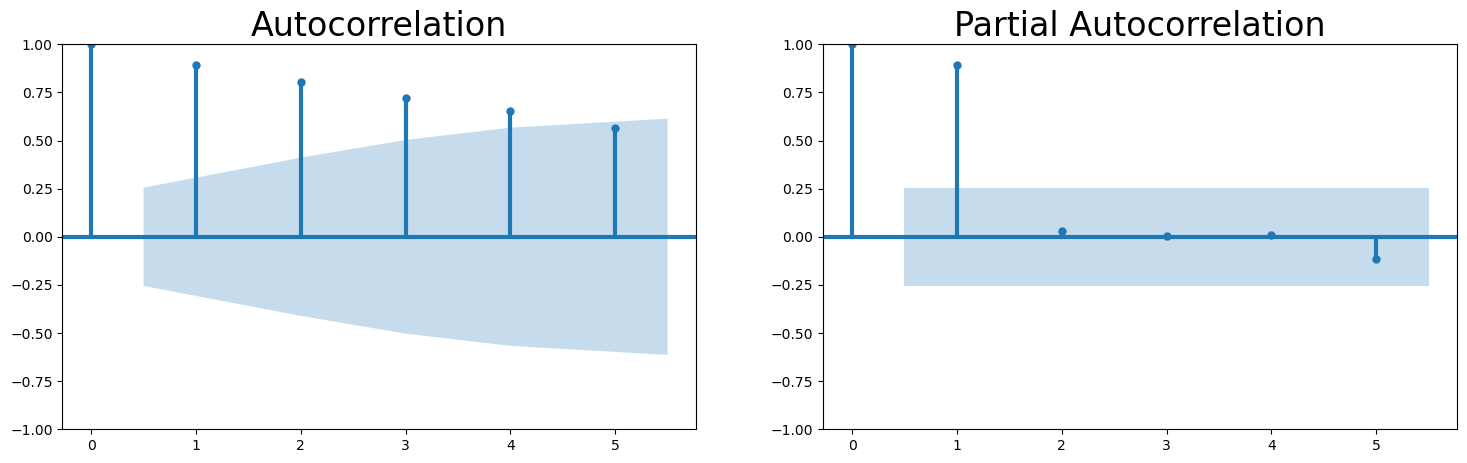

(0.8030073326980115,
 0.9916845572455877,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

In [81]:
plot_acf_pacf(train_df["gdp"])
adfuller(train_df["gdp"])

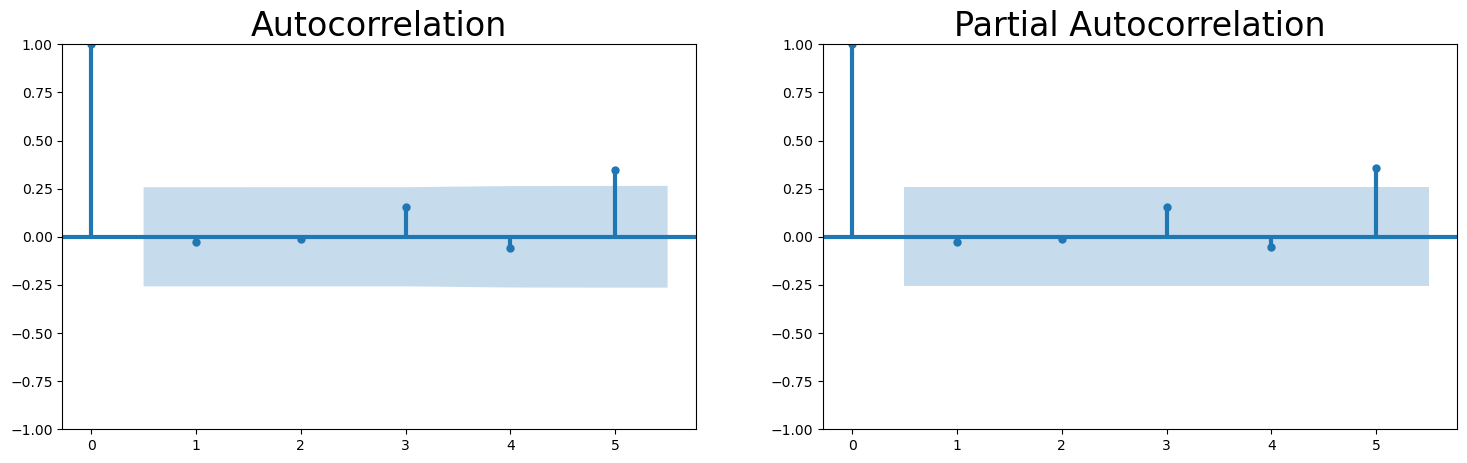

(-1.8255652246436,
 0.36784515276563423,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [82]:
plot_acf_pacf(train_df["gdp"].diff().dropna())
adfuller(train_df["gdp"].diff().dropna())

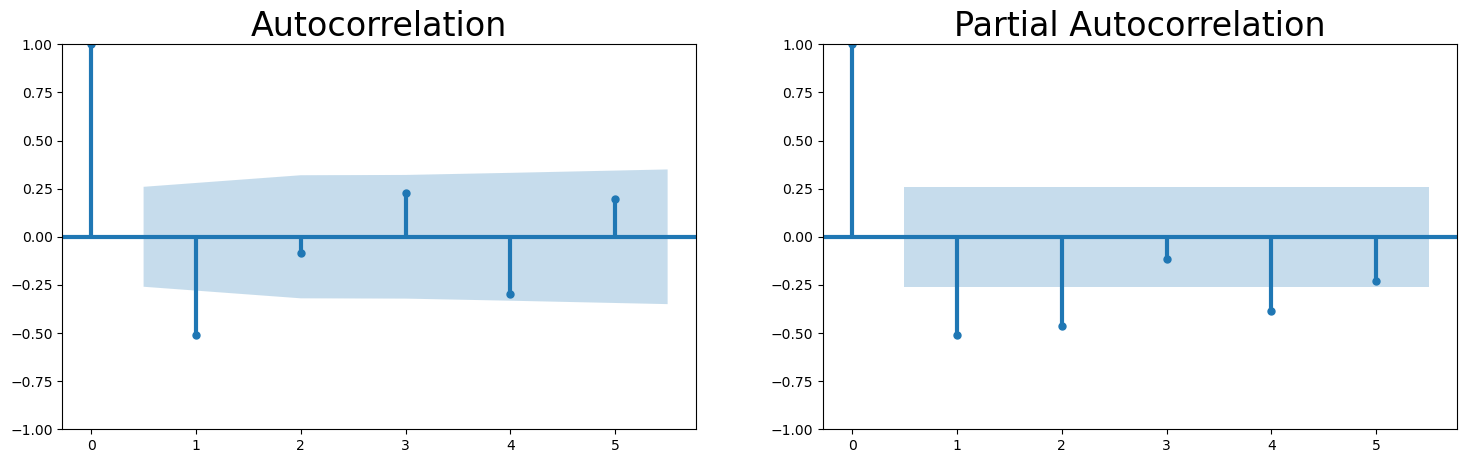

(-2.63463474600784,
 0.08604813722197724,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [83]:
plot_acf_pacf(train_df["gdp"].diff().diff().dropna())
adfuller(train_df["gdp"].diff().diff().dropna())

In [84]:
import pmdarima as pm

smodel_i = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel_i.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.412, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.105, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.664, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.160, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2492.573, Time=0.11 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.412, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.391, Time=0.03 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2489.992, Time=0.16 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2491.982, Time=0.30 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2491.973, Time=0.30 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=inf, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.078
Date:                                Mon, 01 May 2023   AIC                           2486.156
Time:                                        18:22:24   BIC                           2501.918
Sample:                                             0   HQIC                          2492.217
                                                 - 59                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4164      0.136     -3.066      0.002      -0.683      -0.150
ar.L2         -0.9794      0.188     -5.202      0.000      -1.348      -0.610
ma.L1          0.3800      0.239      1.590      0.112      -0.089       0.849
ma.L2          0.9283      0.201      4.617      0.000       0.534       1.322
ma.L3          0.4421      0.186      2.378      0.017       0.078       0.807
ma.S.L5        0.0444      0.261      0.170      0.865      -0.468       0.557
ma.S.L10      -0.4442      0.318     -1.398      0.162      -1.067       0.179
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                69.12
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):             181.21   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.67e+53. Standard errors may be unstable.
"""

In [85]:
smodel_i

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 1, 2, 5),
      suppress_warnings=True, with_intercept=False)

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seas_model_i = SARIMAX(
    train_df["gdp"], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5)
)

seas_model_i = seas_model_i.fit()
seas_model_i.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11198D+01    |proj g|=  3.13345D-01

At iterate    5    f=  2.10204D+01    |proj g|=  4.23944D-02


 This problem is unconstrained.



At iterate   10    f=  2.10173D+01    |proj g|=  8.26565D-03

At iterate   15    f=  2.10131D+01    |proj g|=  1.56046D-01

At iterate   20    f=  2.09952D+01    |proj g|=  1.08582D-01

At iterate   25    f=  2.09710D+01    |proj g|=  8.46561D-02

At iterate   30    f=  2.09617D+01    |proj g|=  9.65319D-03

At iterate   35    f=  2.09602D+01    |proj g|=  1.96663D-01

At iterate   40    f=  2.09439D+01    |proj g|=  9.53699D-02

At iterate   45    f=  2.09341D+01    |proj g|=  4.44423D-02

At iterate   50    f=  2.09335D+01    |proj g|=  4.00274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.078
Date:                                Mon, 01 May 2023   AIC                           2486.156
Time:                                        18:24:35   BIC                           2501.918
Sample:                                    01-01-1960   HQIC                          2492.217
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4164      0.136     -3.066      0.002      -0.683      -0.150
ar.L2         -0.9794      0.188     -5.202      0.000      -1.348      -0.610
ma.L1          0.3800      0.239      1.590      0.112      -0.089       0.849
ma.L2          0.9283      0.201      4.617      0.000       0.534       1.322
ma.L3          0.4421      0.186      2.378      0.017       0.078       0.807
ma.S.L5        0.0444      0.261      0.170      0.865      -0.468       0.557
ma.S.L10      -0.4442      0.318     -1.398      0.162      -1.067       0.179
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                69.12
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):             181.21   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.67e+53. Standard errors may be unstable.
"""

In [91]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_i.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = data["gdp"]

forecast = seas_model_i.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

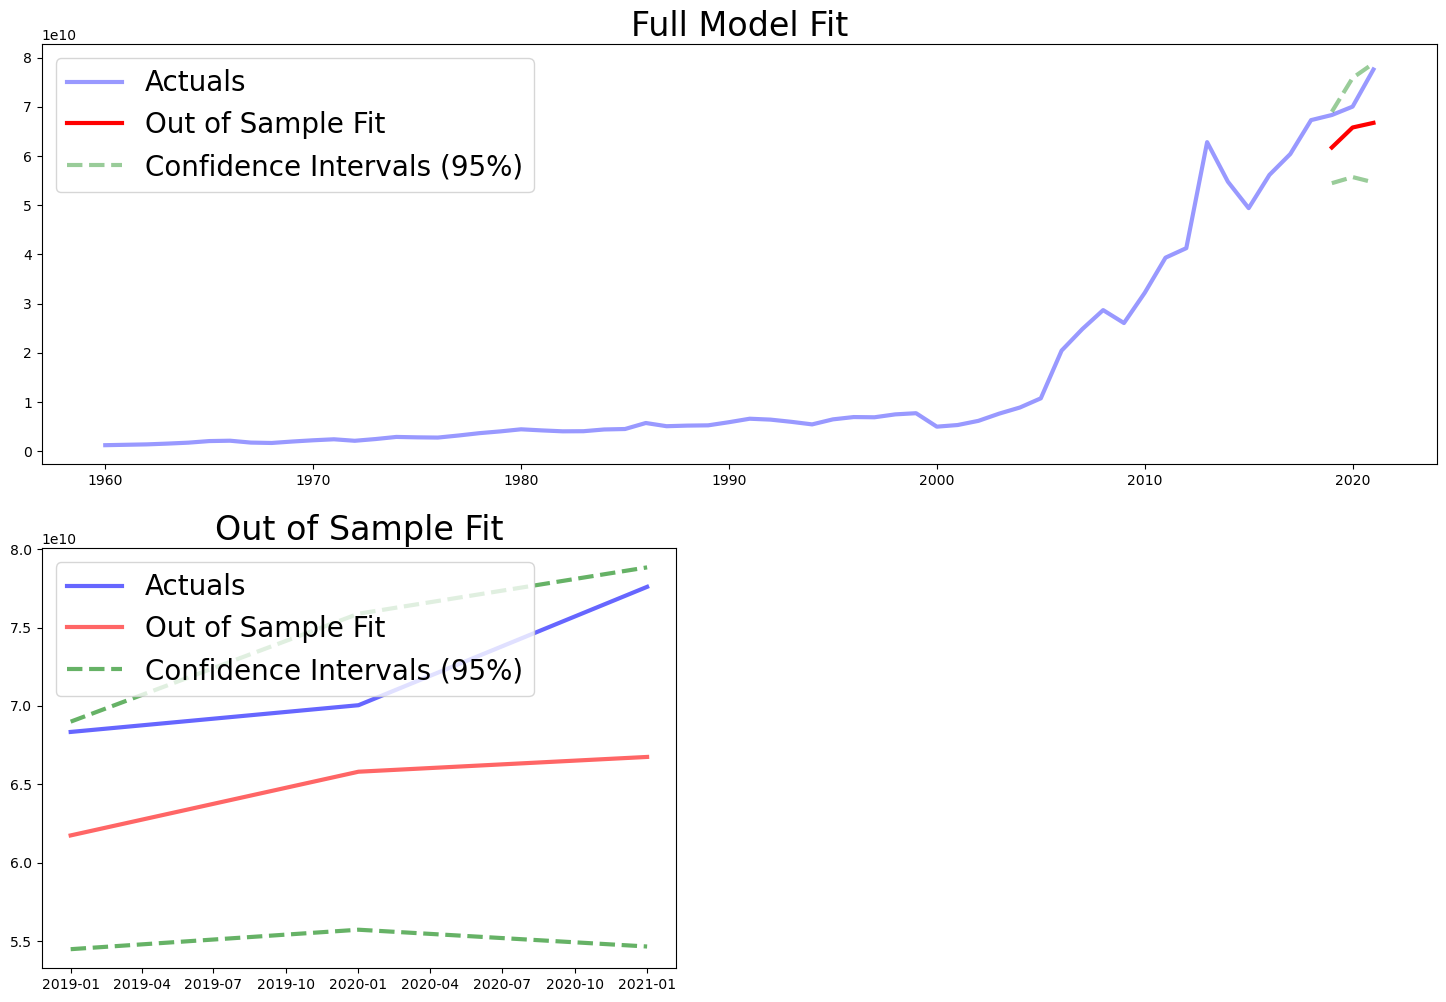

In [92]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [93]:
seas_model_fit.aic - seas_model_i.aic

0.11523848887463828